In [1]:
import xarray as xr
import numpy as np
from google.cloud import storage
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
from pathlib import Path
import ujson
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scores
import pandas as pd
import seaborn as sns
import os
import eccodes
import dask
import cfgrib
import herbie.accessors
import regionmask
import xskillscore
dask.config.set({'temporary_directory': '/mnt/disks/data/'})
sns.set_theme(style='whitegrid',context='talk')

In [2]:
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=2,
    memory_limit='5GiB',
)
client = Client(cluster)


In [3]:
fs_read = fsspec.filesystem('gcs', anon=False, skip_instance_cache=True)
fs_local = fsspec.filesystem('')  
json_dir = 'assets/json/'
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')
so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

def convert_longitude_to_360(longitude):
    return longitude % 360

def generate_json_from_grap_nc(u,fs, fs_out):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)

        file_split = u.split('/') # seperate file path to create a unique name for each json 
        model = file_split[1].split('_')[0]
        date_string = file_split[-1].split('_')[3]
        outf = f'{json_dir}{model}_{date_string}_.json'
        print(outf)
        with fs_out.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

# seasonal aggregation functions for max, min, and mean
def seasonal_subset_max(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.max()

def seasonal_subset_min(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.min()

def seasonal_subset_mean(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.mean()

def is_jja(month):
    return (month >= 6) & (month <= 8)

def is_6_hourly(hour):
    return (hour == 0) | (hour == 6) | (hour == 12) | (hour == 18)


# Load in obs

In [4]:
bounding_box = [-125, -116, 42, 60] # W, E, S, N
temperature_ehe_percentile = 0.85 # Defined as the baseline for a daily min, max, mean, or apparent temperture which is considered an extreme heat event
# 2020 onwards purposefully avoided as recent years were used to train AI models
climatology_min = 1989
climatology_max = 2019

#point obs locations, seatac, bellingham, vancouver, lytton
ksea_coords = (47.44469, -122.31437)
kbli_coords = (48.79269, -122.53753)
cyvr_coords = (49.18303, -123.16823)
cwly_coords = (50.22448, -121.58180)

point_df = pd.DataFrame(
    {
    "longitude": [n[1] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "latitude": [n[0] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "name": ['KSEA', 'KBLI', 'CYVR', 'CWLY']
    }
)

In [15]:
ksea_event_df = pd.read_csv(f'assets/data/KSEA_event.csv').dropna()
ksea_event_df['valid'] = pd.to_datetime(ksea_event_df['valid'])
ksea_event_df['tmpc'] = ksea_event_df['tmpc'].astype(float)
ksea_event_df = ksea_event_df.set_index('valid')
ksea_event_df = ksea_event_df.resample('h').mean(numeric_only=True)
ksea_event_df = ksea_event_df[['tmpc']]
ksea_event_df['stationid'] = 'KSEA'

In [6]:
point_obs_dict = {}
point_obs_dict['KSEA'] = {}
point_obs_dict['KBLI'] = {}
point_obs_dict['CYVR'] = {}
point_obs_dict['CWLY'] = {}

for station in point_obs_dict.items():
    station[1]['data'] = pd.read_csv(f'assets/data/{station[0]}.csv').dropna()
    station[1]['data']['valid'] = pd.to_datetime(station[1]['data']['valid'])
    station[1]['data']['tmpc'] = station[1]['data']['tmpc'].astype(float)
    station[1]['data'] = station[1]['data'].set_index('valid')
    station[1]['data'] = station[1]['data'].resample('h').mean(numeric_only=True)
    station[1]['data']['stationid'] = station[0]
    station[1]['data'] = station[1]['data'].resample('6h').first(numeric_only=True)
    station[1]['85th_percentile_climatology'] = station[1]['data'].groupby([station[1]['data'].index.month, station[1]['data'].index.day, station[1]['data'].index.hour])['tmpc'].transform(lambda x: np.nanpercentile(x, 85))

 

In [7]:
if os.path.exists('assets/data/asos_pangu.csv'):
    asos_pang_df = pd.read_csv('assets/data/asos_pangu.csv')
    asos_pang_df['time'] = pd.to_datetime(asos_pang_df['time'])
else:
    asos_pang_df = pd.DataFrame()
    for json_file in json_list:
        fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                        remote_protocol='gcs', remote_options={'anon':True})
        m = fs_.get_mapper("")
        ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
        locations_df = pd.DataFrame()
        for i, row in point_df.iterrows():
            model_run_time = np.datetime64(pd.to_datetime(ds.attrs['initialization_time']))

            fhours = ds['time'] - model_run_time
            fhours = fhours.values/ np.timedelta64(1, 'h')
            df = ds['t2'].sel(longitude=convert_longitude_to_360(row['longitude']),latitude=row['latitude'],method='nearest').to_dataframe()
            df['stationid'] = row['name']
            df['fhour'] = fhours
            df['init_time'] = model_run_time
            locations_df = pd.concat([df,locations_df])
        asos_pang_df['t2c'] = asos_pang_df['t2'] - 273.15
        asos_pang_df = pd.concat([asos_pang_df,locations_df])
    asos_pang_df.to_csv('assets/data/asos_pangu.csv')

Text(0.5, 1.0, 'KSEA 85th Percentile Climatology')

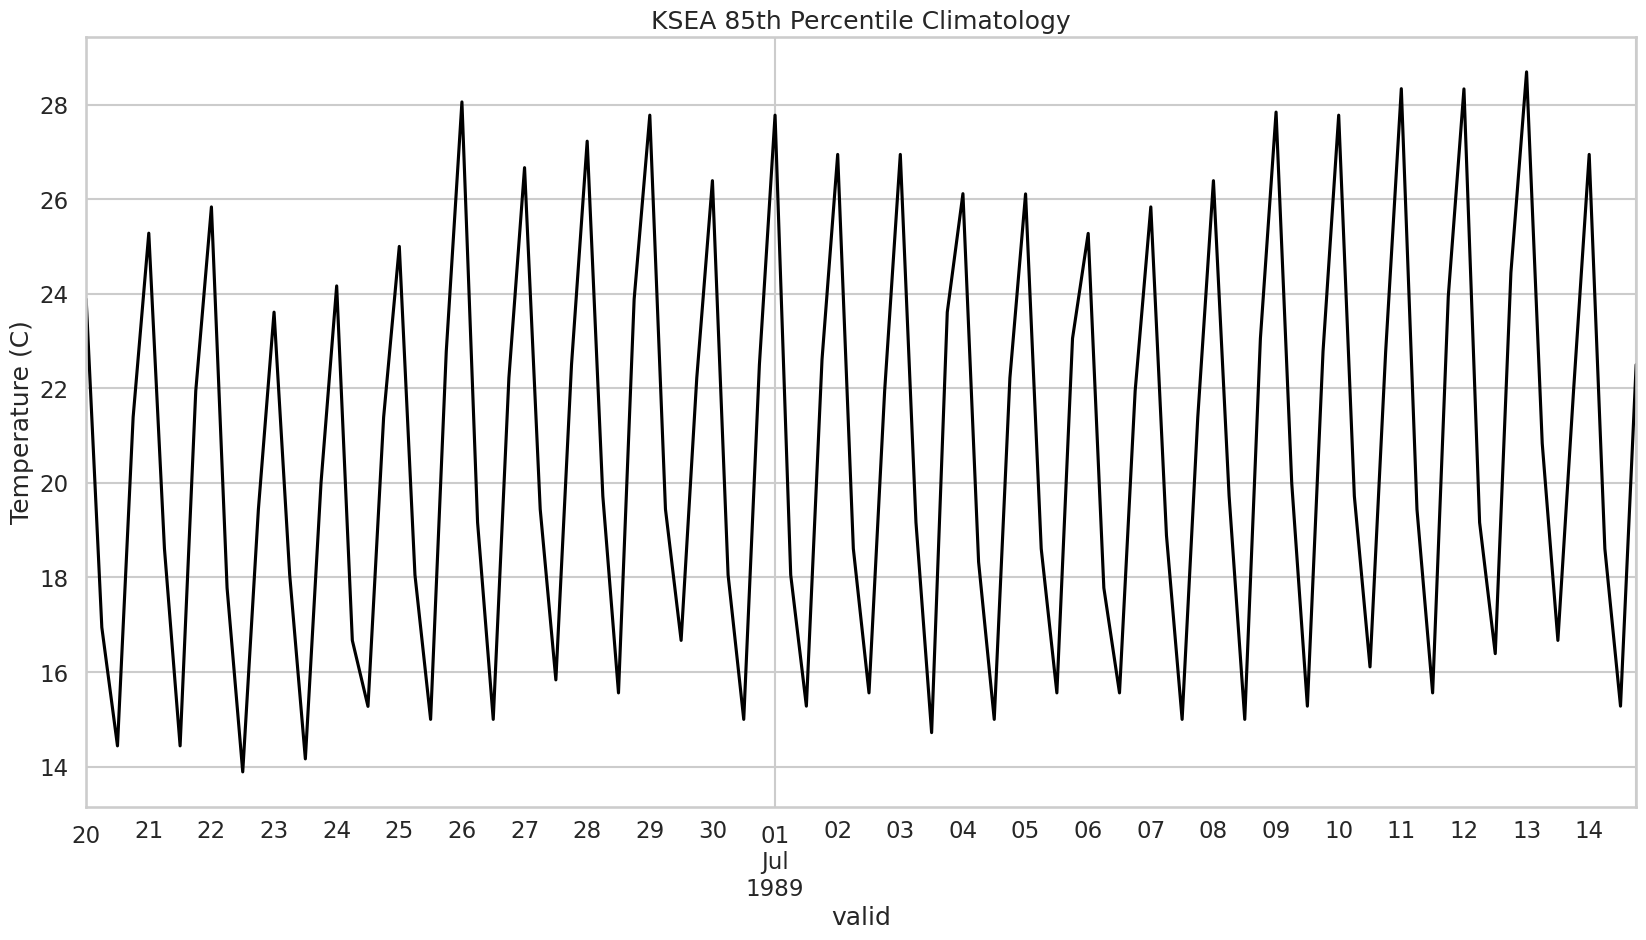

In [8]:
point_obs_dict['KSEA']['85th_percentile_climatology'].iloc[680:780].plot(figsize=(20,10),legend=False,x='month_day_hour', y='tmpc', label='Observed 85th Percentile Climatology', color='black')
plt.ylabel('Temperature (C)')
plt.title('KSEA 85th Percentile Climatology')

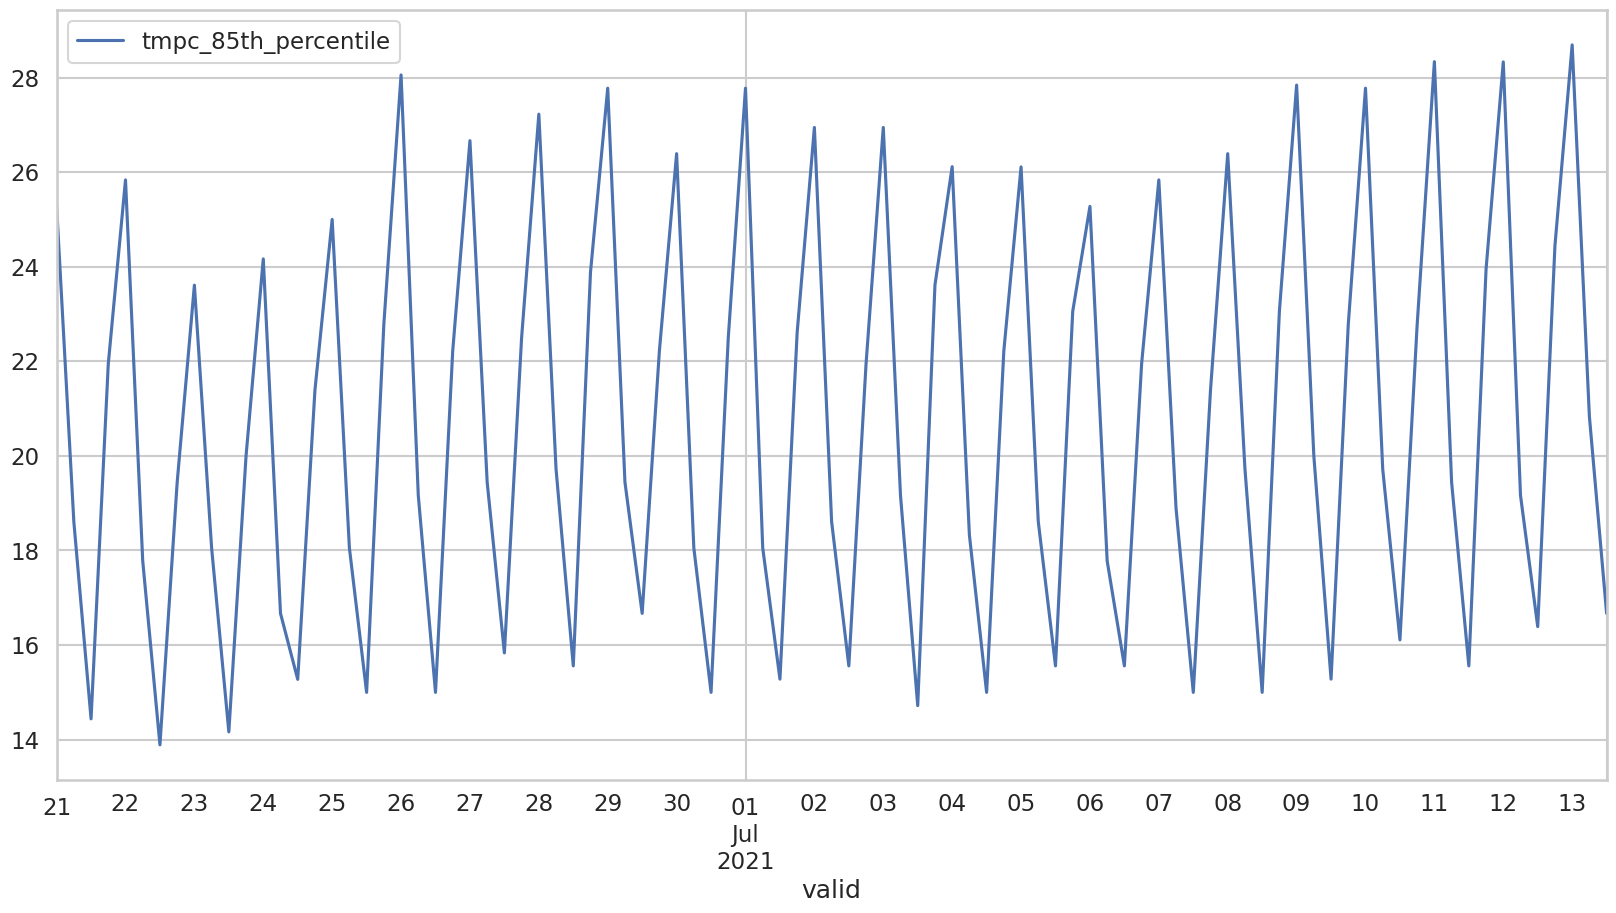

In [23]:
ksea_merged_df = asos_pang_df.reset_index().rename(columns={'time':'valid'}).merge(ksea_event_df.reset_index(),on=['stationid','valid'])
ksea_merged_df = ksea_merged_df[ksea_merged_df['fhour']>=0]
# Extract month, day, and hour from 'valid' datetime in ksea_merged_df
ksea_merged_df['month_day_hour'] = ksea_merged_df['valid'].dt.strftime('%m-%d %H')

# Extract month, day, and hour from the index of '85th_percentile_climatology' in point_obs_dict['KSEA']
point_obs_dict['KSEA']['85th_percentile_climatology'] = point_obs_dict['KSEA']['85th_percentile_climatology'].reset_index()
point_obs_dict['KSEA']['85th_percentile_climatology']['month_day_hour'] = point_obs_dict['KSEA']['85th_percentile_climatology']['valid'].dt.strftime('%m-%d %H')

# Merge on 'month_day_hour'
ksea_merged_df = ksea_merged_df.merge(point_obs_dict['KSEA']['85th_percentile_climatology'][['month_day_hour', 'tmpc']], on='month_day_hour', suffixes=('', '_85th_percentile'))

# Drop the 'month_day_hour' column as it's no longer needed
ksea_merged_df = ksea_merged_df.drop(columns=['month_day_hour'])

ksea_merged_df = ksea_merged_df.drop_duplicates(subset=['valid'], keep='first')
ksea_merged_df.plot(y='tmpc_85th_percentile', x='valid', figsize=(20,10))
ksea_merged_df['t2c'] = ksea_merged_df['t2'] - 273.15

# Duration MAE and ME

In [17]:
merged_df['t2c'] = merged_df['t2'] - 273.15

In [ ]:
# Convert 'valid' to datetime if not already
merged_df['valid'] = pd.to_datetime(merged_df['valid'])

# Filter the dataframe for dates after June 24 - event start date - 2 days
filtered_df = merged_df[merged_df['valid'] > '2021-06-24']

# Group by 'init_time' and find the first 'valid' where 't2c' is greater than '85th_percentile_by_hour'
result = filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['85th_percentile_by_hour']].iloc[0])

# Reset index to get a clean dataframe
result = result.reset_index(drop=True)
# Find the first time ksea_event_df's 'tmpc' was greater than '85th_percentile_by_hour'
first_exceedance_time = ksea_event_df_subset[(ksea_event_df_subset['tmpc'] > ksea_event_df_subset['85th_percentile_by_hour']) & (ksea_event_df_subset['valid']>='2021-06-23')].min()['valid']   

# Ensure first_exceedance_time is a Timestamp object
first_exceedance_time = pd.to_datetime(first_exceedance_time)

# Calculate the time difference and create the 'begin_error' column
result['begin_error'] = result['valid'] - first_exceedance_time

result = result[result['init_time'] <= '2021-06-26']

/tmp/ipykernel_18938/2175111792.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = filtered_df.groupby('init_time').apply(lambda x: x[x['t2c'] > x['85th_percentile_by_hour']].iloc[0])


In [13]:
result

,valid,latitude,longitude,t2,stationid,fhour,init_time,t2c,tmpc,85th_percentile_by_hour,begin_error
0,2021-06-24 12:00:00,47.5,237.75,288.760345,KSEA,84.0,2021-06-21 00:00:00,15.610352,13.33,15.56,-1 days +06:00:00
1,2021-06-25 12:00:00,47.5,237.75,289.729187,KSEA,96.0,2021-06-21 12:00:00,16.579193,19.44,15.56,0 days 06:00:00
2,2021-06-25 12:00:00,47.5,237.75,288.813293,KSEA,84.0,2021-06-22 00:00:00,15.663300,19.44,15.56,0 days 06:00:00
3,2021-06-25 12:00:00,47.5,237.75,289.708282,KSEA,72.0,2021-06-22 12:00:00,16.558289,19.44,15.56,0 days 06:00:00
4,2021-06-25 12:00:00,47.5,237.75,289.572876,KSEA,60.0,2021-06-23 00:00:00,16.422882,19.44,15.56,0 days 06:00:00
5,2021-06-26 06:00:00,47.5,237.75,293.984741,KSEA,66.0,2021-06-23 12:00:00,20.834747,26.67,19.44,1 days 00:00:00
6,2021-06-24 06:00:00,47.5,237.75,293.064514,KSEA,6.0,2021-06-24 00:00:00,19.914520,16.67,19.44,-1 days +00:00:00
7,2021-06-26 06:00:00,47.5,237.75,293.512756,KSEA,42.0,2021-06-24 12:00:00,20.362762,26.67,19.44,1 days 00:00:00
8,2021-06-25 06:00:00,47.5,237.75,293.724152,KSEA,6.0,2021-06-25 00:00:00,20.574158,21.11,19.44,0 days 00:00:00
9,2021-06-25 12:00:00,47.5,237.75,289.902832,KSEA,0.0,2021-06-25 12:00:00,16.752838,19.44,15.56,0 days 06:00:00


In [14]:
# Filter the dataframe for dates after June 26 00Z, the start of the heatwave
filtered_df_below = ksea_merged_df[ksea_merged_df['valid'] > '2021-06-26 00:00:00']

# Group by 'init_time' and find the first 'valid' where 't2c' is less than '85th_percentile_by_hour'
result_below = filtered_df_below.groupby('init_time').apply(lambda x: x[x['t2c'] < x['85th_percentile_by_hour']].iloc[0] if not x[x['t2c'] < x['85th_percentile_by_hour']].empty else pd.Series([np.nan]*x.shape[1], index=x.columns))
# Drop empty rows
result_below = result_below.dropna().reset_index(drop=True)

# Find the first time ksea_event_df's 'tmpc' was less than '85th_percentile_by_hour'
first_below_time = ksea_event_df_subset[(ksea_event_df_subset['tmpc'] < ksea_event_df_subset['85th_percentile_by_hour']) & (ksea_event_df_subset['valid'] > '2021-06-26 00:00:00')].min()['valid']

# Ensure first_below_time is a Timestamp object
first_below_time = pd.to_datetime(first_below_time)

# Calculate the time difference and create the 'end_error' column
result_below['end_error'] = result_below['valid'] - first_below_time

/tmp/ipykernel_18938/2688367609.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_below = filtered_df_below.groupby('init_time').apply(lambda x: x[x['t2c'] < x['85th_percentile_by_hour']].iloc[0] if not x[x['t2c'] < x['85th_percentile_by_hour']].empty else pd.Series([np.nan]*x.shape[1], index=x.columns))


In [15]:
result

,valid,latitude,longitude,t2,stationid,fhour,init_time,t2c,tmpc,85th_percentile_by_hour,begin_error
0,2021-06-24 12:00:00,47.5,237.75,288.760345,KSEA,84.0,2021-06-21 00:00:00,15.610352,13.33,15.56,-1 days +06:00:00
1,2021-06-25 12:00:00,47.5,237.75,289.729187,KSEA,96.0,2021-06-21 12:00:00,16.579193,19.44,15.56,0 days 06:00:00
2,2021-06-25 12:00:00,47.5,237.75,288.813293,KSEA,84.0,2021-06-22 00:00:00,15.663300,19.44,15.56,0 days 06:00:00
3,2021-06-25 12:00:00,47.5,237.75,289.708282,KSEA,72.0,2021-06-22 12:00:00,16.558289,19.44,15.56,0 days 06:00:00
4,2021-06-25 12:00:00,47.5,237.75,289.572876,KSEA,60.0,2021-06-23 00:00:00,16.422882,19.44,15.56,0 days 06:00:00
5,2021-06-26 06:00:00,47.5,237.75,293.984741,KSEA,66.0,2021-06-23 12:00:00,20.834747,26.67,19.44,1 days 00:00:00
6,2021-06-24 06:00:00,47.5,237.75,293.064514,KSEA,6.0,2021-06-24 00:00:00,19.914520,16.67,19.44,-1 days +00:00:00
7,2021-06-26 06:00:00,47.5,237.75,293.512756,KSEA,42.0,2021-06-24 12:00:00,20.362762,26.67,19.44,1 days 00:00:00
8,2021-06-25 06:00:00,47.5,237.75,293.724152,KSEA,6.0,2021-06-25 00:00:00,20.574158,21.11,19.44,0 days 00:00:00
9,2021-06-25 12:00:00,47.5,237.75,289.902832,KSEA,0.0,2021-06-25 12:00:00,16.752838,19.44,15.56,0 days 06:00:00


In [17]:
merged_result = pd.merge(result, result_below, on='init_time', suffixes=('_above', '_below'))
merged_result['time_mae'] = (merged_result['begin_error'].abs() + merged_result['end_error'].abs())/2
merged_result['time_me'] = (merged_result['begin_error'] + merged_result['end_error'])/2
merged_result['time_mae_hours'] = merged_result['time_mae'].dt.total_seconds() / 3600
merged_result['begin_time_hours'] = merged_result['begin_error'].dt.total_seconds() / 3600
merged_result['end_time_hours'] = merged_result['end_error'].dt.total_seconds() / 3600
merged_result['time_me_hours'] = merged_result['time_me'].dt.total_seconds() / 3600

Text(0.5, 1.0, 'Event Duration MAE (hours)')

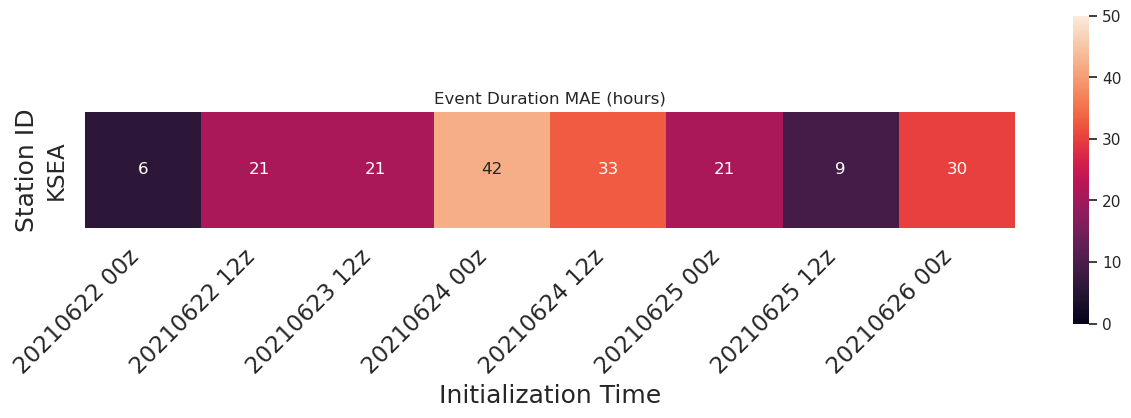

In [ ]:
merged_pivot = merged_result.pivot(index='stationid_above', columns='init_time', values='time_mae_hours')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=0, vmax=50, square=True)
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Station ID')
ax.set_xlabel('Initialization Time')
ax.set_title('Event Duration MAE (hours)')

Text(0.5, 1.0, 'Event Duration ME (hours)')

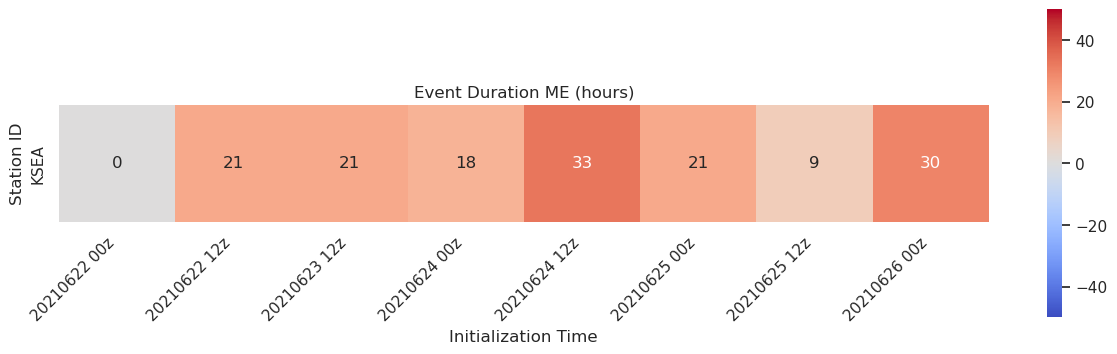

In [20]:
merged_pivot = merged_result.pivot(index='stationid_above', columns='init_time', values='time_me_hours')
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(font_scale=1)
sns.heatmap(merged_pivot, ax=ax, annot=True, vmin=-50, vmax=50, square=True, cmap='coolwarm')
# Set the xticklabels to show datetime in a %Y%m%d %Hz format
ax.set_xticklabels(rotation=45, ha='right', 
                   labels=[pd.to_datetime(label.get_text()).strftime('%Y%m%d %Hz') for label in ax.get_xticklabels()])
ax.set_ylabel('Station ID')
ax.set_xlabel('Initialization Time')
ax.set_title('Event Duration ME (hours)')

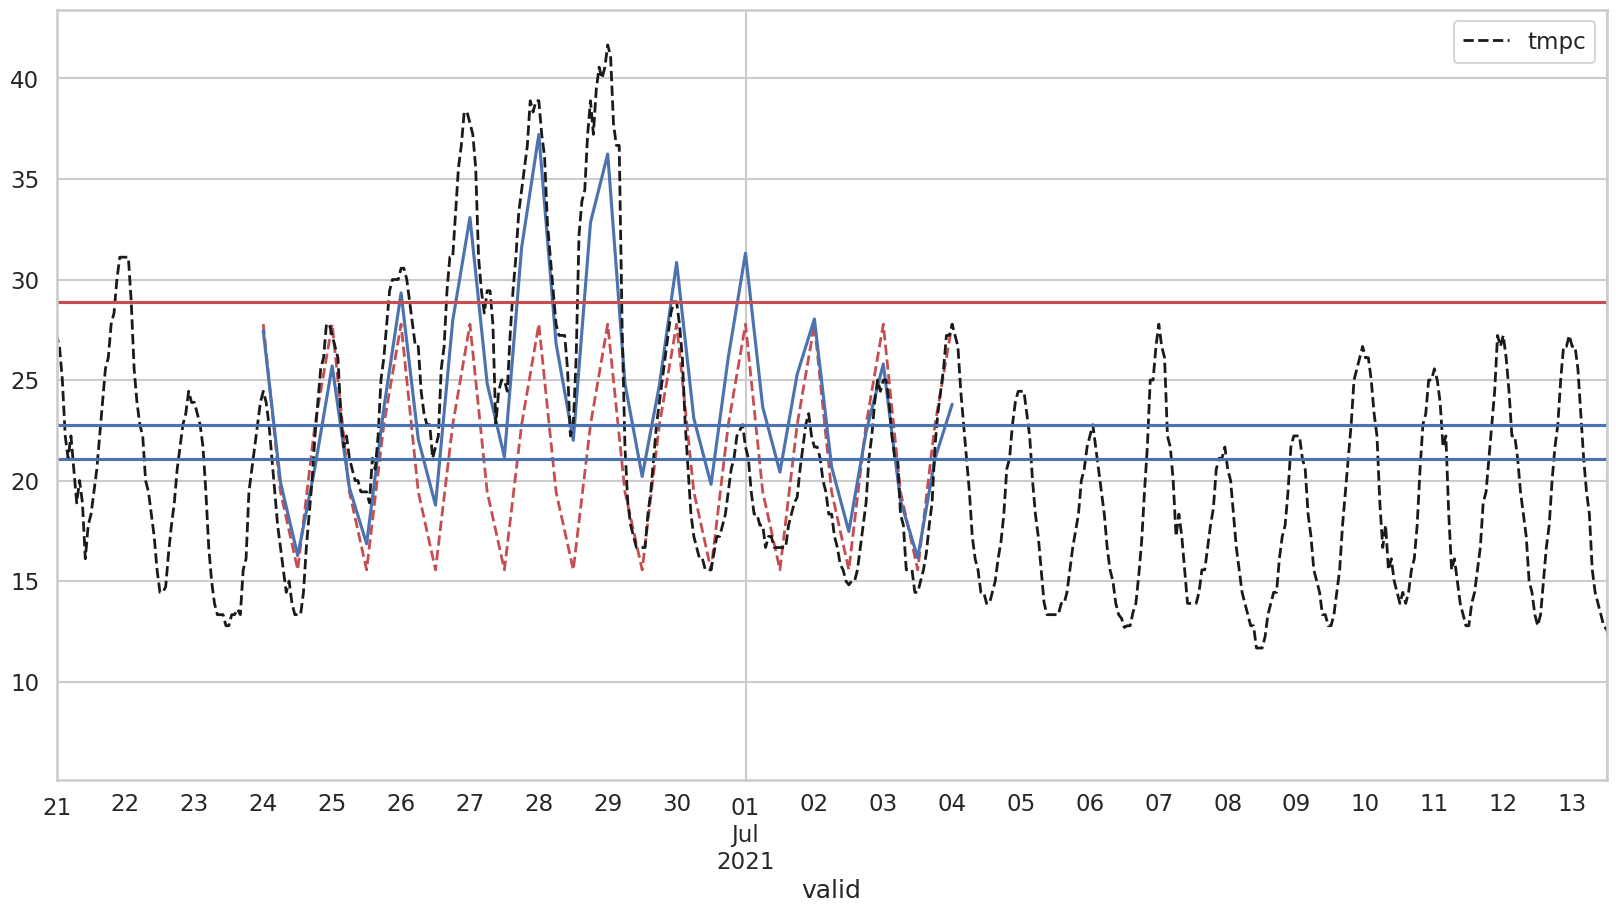

In [82]:
fig, ax = plt.subplots(figsize=(20,10))

ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-24 00'].plot(x='valid',y='85th_percentile_by_hour',ls='--',lw=2,c='r',ax=ax,legend=False)
ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-24 00'].plot(x='valid',y='t2c',ax=ax,legend=False)
ksea_event_df.plot(y='tmpc',ls='--',lw=2,c='k',ax=ax)
ax.set_xlim(ksea_merged_df['valid'].min(),ksea_merged_df['valid'].max())
ax.axhline(point_obs_dict['KSEA']['temp_85th_percentile'])
ax.axhline(point_obs_dict['KSEA']['mean_temp_85th_percentile'])
ax.axhline(point_obs_dict['KSEA']['max_temp_85th_percentile'],c='r')

plt.show()

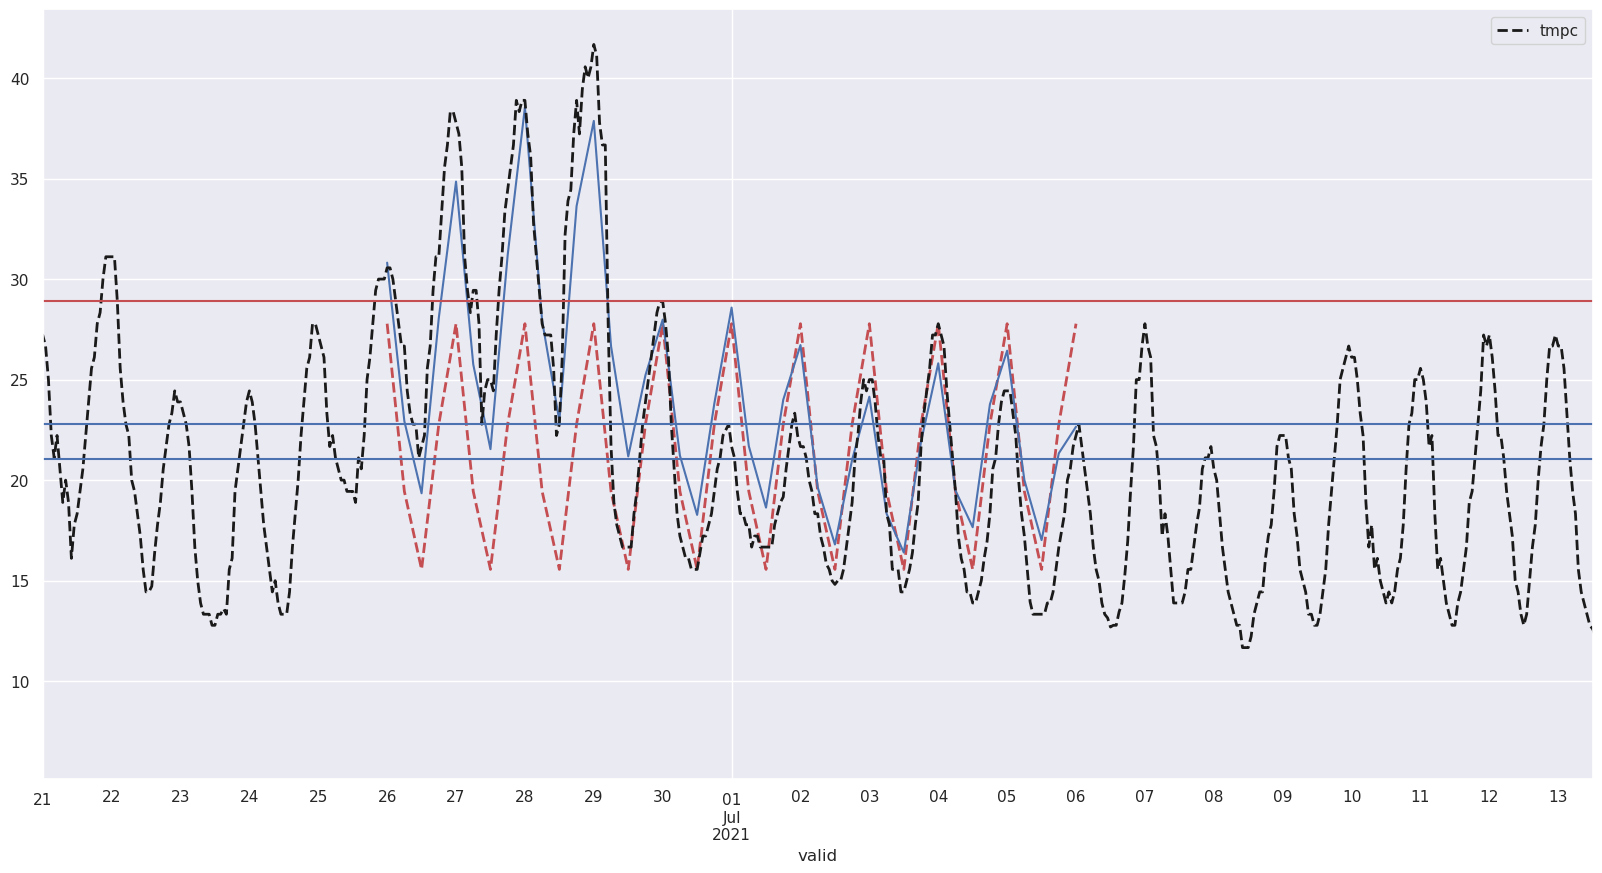

In [43]:
fig, ax = plt.subplots(figsize=(20,10))

ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-26 00'].plot(x='valid',y='85th_percentile_by_hour',ls='--',lw=2,c='r',ax=ax,legend=False)
ksea_merged_df[ksea_merged_df['init_time'] == '2021-06-26 00'].plot(x='valid',y='t2c',ax=ax,legend=False)
ksea_event_df.plot(y='tmpc',ls='--',lw=2,c='k',ax=ax)
ax.set_xlim(ksea_merged_df['valid'].min(),ksea_merged_df['valid'].max())
ax.axhline(point_obs_dict['KSEA']['temp_85th_percentile'])
ax.axhline(point_obs_dict['KSEA']['mean_temp_85th_percentile'])
ax.axhline(point_obs_dict['KSEA']['max_temp_85th_percentile'],c='r')